# Energy cutoff smearing

A technique that has been employed in the literature to ensure smooth energy bands
for finite Ecut values is energy cutoff smearing.

As recalled in the
[Problems and plane-wave discretization](https://docs.dftk.org/stable/guide/periodic_problems/)
section, the energy of periodic systems is computed by solving eigenvalue
problems of the form
$$
H_k u_k = ε_k u_k,
$$
for each $k$-point in the first Brillouin zone of the system.
Each of these eigenvalue problem is discretized with a plane-wave basis
$\mathcal{B}_k^{E_c}=\{x ↦ e^{iG · x} \;\;|\;G ∈ \mathcal{R}^*,\;\; |k+G|^2 ≤ 2E_c\}$
whose size highly depends on the choice of $k$-point, cell size or
cutoff energy $\rm E_c$ (the `Ecut` parameter of DFTK).
As a result, energy bands computed along a $k$-path in the Brillouin zone
or with respect to the system's unit cell volume - in the case of geometry optimization
for example - display big irregularities when `Ecut` is taken too small.

Here is for example the variation of the ground state energy of face cubic centred
(FCC) silicon with respect to its lattice parameter,
around the experimental lattice constant.

In [1]:
using AtomsBuilder
using DFTK
using PseudoPotentialData
using Statistics

a0 = 10.26  # Experimental lattice constant of silicon in bohr
a_list = range(a0 - 1/2, a0 + 1/2; length=20)

function compute_ground_state_energy(a; Ecut, kgrid, kinetic_blowup, kwargs...)
    pseudopotentials = PseudoFamily("cp2k.nc.sr.pbe.v0_1.semicore.gth")
    model  = model_DFT(bulk(:Si); functionals=PBE(), kinetic_blowup, pseudopotentials)
    basis  = PlaneWaveBasis(model; Ecut, kgrid)
    self_consistent_field(basis; callback=identity, kwargs...).energies.total
end

Ecut  = 5          # Very low Ecut to display big irregularities
kgrid = (2, 2, 2)  # Very sparse k-grid to speed up convergence
E0_naive = compute_ground_state_energy.(a_list; kinetic_blowup=BlowupIdentity(), Ecut, kgrid);

To be compared with the same computation for a high `Ecut=100`. The naive approximation
of the energy is shifted for the legibility of the plot.

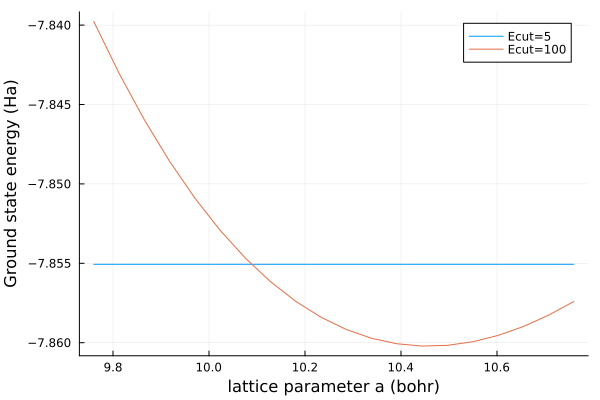

In [2]:
E0_ref = [-7.839775223322127, -7.843031658146996, -7.845961005280923,
          -7.848576991754026, -7.850892888614151, -7.852921532056932,
          -7.854675317792186, -7.85616622262217,  -7.85740584131599,
          -7.858405359984107, -7.859175611288143, -7.859727053496513,
          -7.860069804791132, -7.860213631865354, -7.8601679947736915,
          -7.859942011410533, -7.859544518721661, -7.858984032385052,
          -7.858268793303855, -7.857406769423708]

using Plots
shift = mean(abs.(E0_naive .- E0_ref))
p = plot(a_list, E0_naive .- shift, label="Ecut=5", xlabel="lattice parameter a (bohr)",
         ylabel="Ground state energy (Ha)", color=1)
plot!(p, a_list, E0_ref, label="Ecut=100", color=2)

The problem of non-smoothness of the approximated energy is typically avoided by
taking a large enough `Ecut`, at the cost of a high computation time.
Another method consist in introducing a modified kinetic term defined through
the data of a blow-up function, a method which is also referred to as "energy cutoff
smearing". DFTK features energy cutoff smearing using the CHV blow-up
function introduced in [^CHV2022] that is mathematically ensured to provide $C^2$
regularity of the energy bands.

[^CHV2022]:
   Éric Cancès, Muhammad Hassan and Laurent Vidal
   *Modified-operator method for the calculation of band diagrams of
   crystalline materials*, 2022.
   [arXiv preprint.](https://arxiv.org/abs/2210.00442)

Let us launch the computation again with the modified kinetic term.

In [3]:
E0_modified = compute_ground_state_energy.(a_list; kinetic_blowup=BlowupCHV(), Ecut, kgrid);

> **Abinit energy cutoff smearing option**
>
> For the sake of completeness, DFTK also provides the blow-up function `BlowupAbinit`
> proposed in the Abinit quantum chemistry code. This function depends on a parameter
> `Ecutsm` fixed by the user
> (see [Abinit user guide](https://docs.abinit.org/variables/rlx/#ecutsm)).
> For the right choice of `Ecutsm`, `BlowupAbinit` corresponds to the `BlowupCHV` approach
> with coefficients ensuring $C^1$ regularity. To choose `BlowupAbinit`, pass
> `kinetic_blowup=BlowupAbinit(Ecutsm)` to the model constructors.

We can know compare the approximation of the energy as well as the estimated
lattice constant for each strategy.

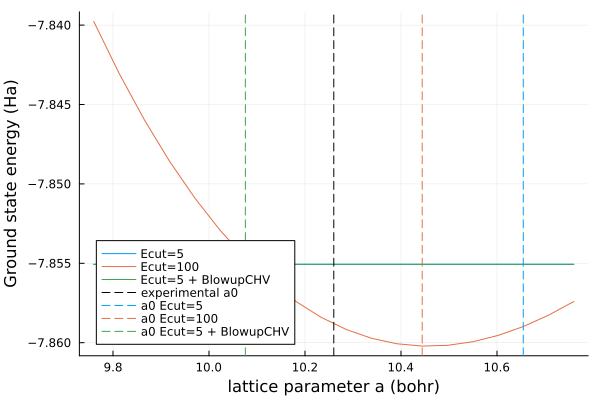

In [4]:
estimate_a0(E0_values) = a_list[findmin(E0_values)[2]]
a0_naive, a0_ref, a0_modified = estimate_a0.([E0_naive, E0_ref, E0_modified])

shift = mean(abs.(E0_modified .- E0_ref))  # Shift for legibility of the plot
plot!(p, a_list, E0_modified .- shift, label="Ecut=5 + BlowupCHV", color=3)
vline!(p, [a0], label="experimental a0", linestyle=:dash, linecolor=:black)
vline!(p, [a0_naive], label="a0 Ecut=5", linestyle=:dash, color=1)
vline!(p, [a0_ref], label="a0 Ecut=100", linestyle=:dash, color=2)
vline!(p, [a0_modified], label="a0 Ecut=5 + BlowupCHV", linestyle=:dash, color=3)

The smoothed curve obtained with the modified kinetic term allow to clearly designate
a minimal value of the energy with respect to the lattice parameter $a$, even with
the low `Ecut=5` Ha.

In [5]:
println("Error of approximation of the reference a0 with modified kinetic term:"*
        " $(round((a0_modified - a0_ref)*100/a0_ref, digits=5))%")

Error of approximation of the reference a0 with modified kinetic term: -3.52751%
